In [1]:
# theano imports
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
# from theano.tensor.signal.downsample import max_pool_2d
from theano.tensor.signal.pool import pool_2d as max_pool_2d
from theano.tensor.nnet import batch_normalization

# other imports
from sklearn.cross_validation import train_test_split
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

### Getting our data in 

In [3]:
# helper function for loading in data of a specific encoding window
def get_data_tensor(n = 5):
    filename = '../conv_data/' + str(n) + '_tensor.p'
    
    with open(filename, 'rb') as f:
        loaded_data = pickle.load(f)
    
    return loaded_data

In [5]:
# read our data in 

n_window = 13
n_aminos = 21

loaded_data = get_data_tensor(n = n_window)
    
labels = pd.read_csv('../one_hot_labels.csv')

In [6]:
loaded_data[:2]    

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [7]:
one_hot = labels.values

In [8]:
one_hot[:2]

array([[ 0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

In [29]:
xTrain, xTest, yTrain, yTest = train_test_split(loaded_data, one_hot)

In [30]:
print xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

(101110, 13, 21) (33704, 13, 21) (101110, 6) (33704, 6)


In [ ]:
xTrain = xTrain.reshape(-1, 1, n_window, n_aminos)
xTest = xTest.reshape(-1, 1, n_window, n_aminos)

In [32]:
print xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

(101110, 1, 13, 21) (33704, 1, 13, 21) (101110, 6) (33704, 6)


## Now time to declare some Theano functions

In [33]:
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def glorot_init_weights(shape):
    (h, w) = shape
    # 0.25 for sigmoid, 0.1 for softmax, 1.0 for tanh/relu
    normalizer = 2.0 * (6**0.5) / ((h + w)**0.5) * 1.0  #factors: 0.1 correct for uni[0,1], glo, glo, softmax deriv
    return theano.shared(floatX((np.random.random_sample(shape) - 0.5) * normalizer))

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def activate(X):
    return T.nnet.relu(X)

def rectify(X):
#     return T.maximum(X, 0.)
    return T.maximum(X, 0.01*X)  #leaky rectifier

#### USE ELU TO AVOID VANISHING GRADS

def ELU(X, alpha=0.1):
    return T.switch(X > 0, X, alpha * (T.exp(X) - 1))
    
def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 1, 'x', 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 1, 'x', 'x')

def dropout(X, p=0.0):
    if p > 0:
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    
    return updates

def model(X, wi, wh, bh, wo, bo, p_drop_conv, p_drop_hidden):
    
    # --------------------------------------------
    
    layer_1 = conv2d(X, wi, border_mode='valid')
    layer_1 = layer_1.reshape((-1, 256))
    layer_1 = dropout(layer_1, p_drop_conv)

    # --------------------------------------------
    
    layer_2 = T.dot(layer_1, wh) + bh    
    layer_2 = activate(layer_2)
    layer_2 = dropout(layer_2, p_drop_hidden)
    
    # --------------------------------------------
    
    layer_3 = T.dot(layer_2, wo) + bo
    layer_3 = dropout(layer_3, p_drop_hidden)
    
    # --------------------------------------------
    
#     pyx = softmax(layer_3)
    pyx = T.nnet.softmax(layer_3)
    return layer_1, layer_2, layer_3, pyx

## Trying to implement batch normalization

In [17]:
# hoping to get batch normalization implemented below
# data, input weights, gamma input, beta input, hidden weights, hidden bias, gamma hidden, beta hidden, 
# output weights, output bias, gamma output, beta output, p_drop, p_hidden_drop
def model_bn(X, wi, gi, bbi, wh, bh, gh, bbh, wo, bo, go, bbo, p_drop_conv, p_drop_hidden):

    # --------------------------------------------
    
    layer_1 = conv2d(X, wi, border_mode='valid')
    layer_1 = layer_1.reshape((-1, 256))
    layer_1 = batch_normalization(layer_1, gamma=gi, beta=bbi, 
                                 mean=layer_1.mean((0, ), keepdims=True), 
                                  std = T.ones_like(layer_1.var((0,), keepdims=True)), 
                                  mode='high_mem')

    layer_1 = dropout(layer_1, p_drop_conv)

    # --------------------------------------------
    
    layer_2 = T.dot(layer_1, wh) + bh
    layer_2 = batch_normalization(layer_2, gamma=gh, beta=bbh, 
                                 mean=X.mean((0, ), keepdims=True), 
                                  std = T.ones_like(layer_2.var((0,), keepdims=True)), 
                                  mode='high_mem')
    
    layer_2 = activate(layer_2)
    layer_2 = dropout(layer_2, p_drop_hidden)
    
    # --------------------------------------------
    
    layer_3 = T.dot(layer_2, wo) + bo
    layer_3 = batch_normalization(layer_3, gamma=go, beta=bbo, 
                                 mean=X.mean((0, ), keepdims=True), 
                                  std = T.ones_like(layer_3.var((0,), keepdims=True)), 
                                  mode='high_mem')
    
    layer_3 = dropout(layer_3, p_drop_hidden)
    
    # --------------------------------------------
    
    # thinks it's getting a 4D Tensor ???
#     pyx = softmax(layer_3)
    pyx = T.nnet.softmax(layer_3)
    return layer_1, layer_2, layer_3, pyx

In [18]:
X = T.ftensor4()
Y = T.fmatrix()

# define number of desired features out of convolution
n_conv = 256

# define hidden layer depth
h_depth = 600

# define output layer size
o_depth = 6

# # --------------------------- FOR BATCH NORMALIZATION (NOT WORKING) -----------------------

# # initialize weight matrices: wi, gi, bbi, wh, bh, gh, bbh, wo, bo, go, bbo

# # input parameters
# wi = init_weights((n_conv, 1, n_window, n_aminos))
# gi = theano.shared(floatX(np.ones(n_conv)))
# bbi = theano.shared(floatX(np.zeros(n_conv)))

# # hidden parameters
# wh = glorot_init_weights((n_conv, h_depth))
# bh = theano.shared(floatX(np.zeros(h_depth)))
# gh = theano.shared(floatX(np.ones(h_depth)))
# bbh = theano.shared(floatX(np.zeros(h_depth)))

# # output parameters
# wo = glorot_init_weights((h_depth, o_depth))
# bo = theano.shared(floatX(np.zeros(o_depth)))
# go = theano.shared(floatX(np.ones(o_depth)))
# bbo = theano.shared(floatX(np.zeros(o_depth)))

# modeling and parameters for Gradient Descent
# noise_l1, noise_l2, noise_l3, noise_py_x = model(X, wi, gi, bbi, wh, bh, gh, bbh, wo, bo, go, bbo, 0.2, 0.5)
# l1, l2, l3, py_x = model(X, wi, gi, bbi, wh, bh, gh, bbh, wo, bo, go, bbo, 0., 0.)
# params = [wi, gi, bbi, wh, bh, gh, bbh, wo, bo, go, bbo]

# ----------------------------- FOR WITHOUT BATCH NORMALIZATION------------------------------

# input parameters
wi = init_weights((n_conv, 1, n_window, n_aminos))

# hidden parameters
wh = glorot_init_weights((n_conv, h_depth))
bh = theano.shared(floatX(np.zeros(h_depth)))

# output parameters
wo = glorot_init_weights((h_depth, o_depth))
bo = theano.shared(floatX(np.zeros(o_depth)))

# modeling and parameters for Gradient Descent
params = [wi, wh, bh, wo, bo]
noise_l1, noise_l2, noise_l3, noise_py_x = model(X, wi, wh, bh, wo, bo, 0.2, 0.5)
l1, l2, l3, py_x = model(X, wi, wh, bh, wo, bo, 0., 0.)

# -------------------------------------------------------------------------------------------

params = [wi, wh, bh, wo, bo]
noise_l1, noise_l2, noise_l3, noise_py_x = model(X, wi, wh, bh, wo, bo, 0.2, 0.5)
l1, l2, l3, py_x = model(X, wi, wh, bh, wo, bo, 0., 0.)

y_x = T.argmax(py_x, axis=1)
cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
updates = RMSprop(cost, params, lr=1e-4) #lr=1e-7 <--- way too small of a LR

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

In [19]:
# number of training iterations to perform
n_train = 31

# define mini-batch size
mbs = 128

# store our results
costs = []
test_scores = []
train_scores = []

# performing our training
for i in xrange(n_train):
    
    for start, end in zip(xrange(0, len(xTrain), mbs), 
                          xrange(mbs, len(xTrain), mbs)):
    
        cost = train(xTrain[start:end], yTrain[start:end])
    
    costs.append(cost)
    
    train_score = np.mean(np.argmax(yTrain, axis=1) == predict(xTrain)) 
    test_score = np.mean(np.argmax(yTest, axis=1) == predict(xTest))
    
    test_scores.append(test_score)
    train_scores.append(train_score)
    
    print 'iteration:', i, '-------', 'train:', round(train_score, 3), '-------', 'test:', round(test_score, 3)
    print wi.eval()[0][0][0][:5] # take a quick look at conv filter
    print '-'*60
    
# got up to about 67% w/ 5 vectors!
# up to like 69% with a 9 vector

0 train: 0.616 test: 0.615
[-0.00236347  0.00498965 -0.01400934 -0.00240329 -0.01735711]
------------------------------------------------------------
1 train: 0.628 test: 0.625
[-0.00024778  0.01053106 -0.0148515  -0.00174966 -0.01836091]
------------------------------------------------------------
2 train: 0.631 test: 0.627
[ 0.00016058  0.01354229 -0.0184313  -0.00202013 -0.01682121]
------------------------------------------------------------
3 train: 0.63 test: 0.626
[ 0.00239165  0.01106453 -0.01809614 -0.00085728 -0.01562281]
------------------------------------------------------------
4 train: 0.632 test: 0.626
[ 0.00257162  0.01443604 -0.01844211 -0.002205   -0.01596752]
------------------------------------------------------------
5 train: 0.634 test: 0.628
[ 0.00598948  0.01894306 -0.02207242 -0.00239292 -0.01499586]
------------------------------------------------------------
6 train: 0.635 test: 0.627
[ 0.00676051  0.02078806 -0.02364528 -0.00441084 -0.01574109]
------------

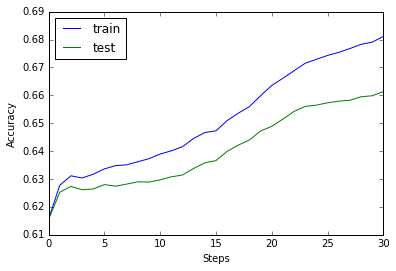

In [21]:
plt.plot(xrange(n_train), train_scores, label='train')
plt.plot(xrange(n_train), test_scores, label='test')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=2);

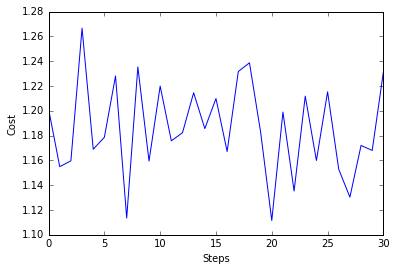

In [22]:
# plot our results
plt.plot(xrange(n_train), costs)
plt.xlabel('Steps')
plt.ylabel('Cost');

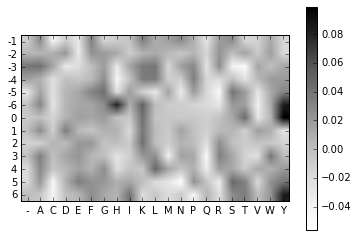

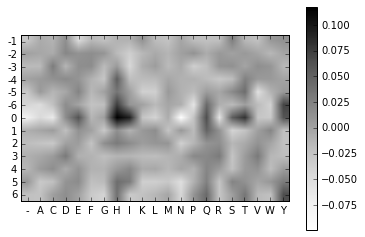

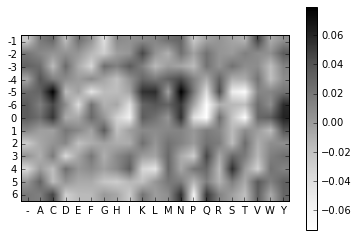

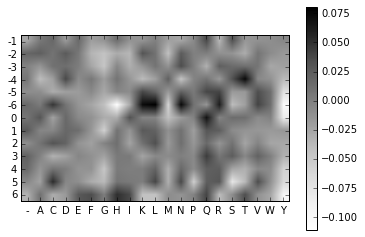

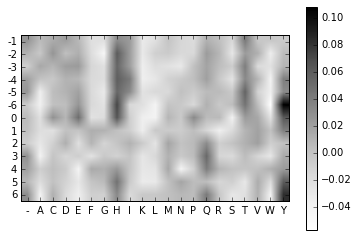

In [48]:
# AMINO MAPS (n_window, 21)
aminos = ['-','A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
# positions = ['-1', '-2', '0', '1', '2']

positions = sorted(map(str, range(-(n_window-1)//2, (n_window+1)//2, 1)))

for conv in wi.eval()[:5]:
    c = conv.reshape(n_window, n_aminos)
    plt.imshow(c, cmap='Greys')
    plt.xticks(range(len(aminos)), aminos)
    plt.yticks(range(len(positions)), positions)
    plt.colorbar()
    plt.show()

http://deeplearning.net/software/theano/library/tensor/nnet/nnet.html#tensor.nnet.softmax
http://deeplearning.net/software/theano/library/tensor/nnet/conv.html#theano.tensor.nnet.conv.conv2d